# Import liberaries 

In [ ]:
!pip install pycaret[full]
! pip uninstall Jinja2 --yes
! pip install Jinja2

In [ ]:
pip install pyod

In [19]:
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

import seaborn as sns
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
import seaborn as sns
from sklearn.datasets import make_blobs
from yellowbrick.cluster import InterclusterDistance
from sklearn.datasets import make_blobs, make_circles, make_s_curve
plt.rcParams["figure.figsize"] = (9,6)

import warnings
warnings.filterwarnings('ignore')

# Fetch the data

In [5]:
import numpy as np
import pandas as pd

#============= Read CSV and apply data preperation =============#
df = pd.read_csv("Dataset_to_be_used_in_anomaly_detection.csv")
df1= pd.read_csv("Dataset_to_be_used_in_performance_comparison.csv")

In [6]:
data=df.iloc[:,:-1]
target=df1['labels']
X = np.array(data)
Y= np.array(target)

In [7]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

# SVM

In [21]:
from sklearn import svm
from pyod.models.ecod import ECOD
clf = ECOD()
clf.fit(X)

# get outlier scores
y_train_labels = clf.labels_  # raw outlier scores on the train data


In [22]:
target_names = ['class 0', 'class 1']
print(classification_report(Y, y_train_labels, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      0.97      0.95        86
     class 1       0.70      0.58      0.64        12

    accuracy                           0.92        98
   macro avg       0.82      0.77      0.80        98
weighted avg       0.91      0.92      0.92        98



# KNN

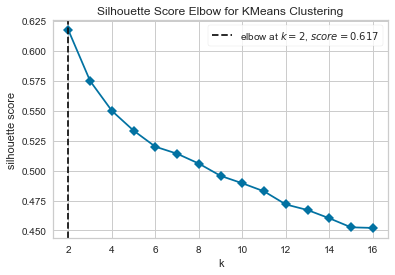

In [16]:
from yellowbrick.cluster.elbow import kelbow_visualizer
model = kelbow_visualizer(KMeans(random_state=0), X, k=(2,17),metric='silhouette',timings=False)  

pass

In [17]:
from pyod.models.knn import KNN   # kNN detector
# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)

target_names = ['class 0', 'class 1']
print(classification_report(Y, y_train_pred, target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.86      0.88      0.87        86
     class 1       0.00      0.00      0.00        12

    accuracy                           0.78        98
   macro avg       0.43      0.44      0.44        98
weighted avg       0.76      0.78      0.77        98



# PCA

In [23]:
from pyod.models.pca import PCA  # kNN detector
# train kNN detector
clf_name = 'PCA'
clf = PCA()
clf.fit(X)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)

target_names = ['class 0', 'class 1']
print(classification_report(Y, y_train_pred, target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98        86
     class 1       0.90      0.75      0.82        12

    accuracy                           0.96        98
   macro avg       0.93      0.87      0.90        98
weighted avg       0.96      0.96      0.96        98



# DBSCAN

In [12]:
def draw_Tsne(x,y, title = "training data"):
  
  data=x                               
  data_labels=y                        
  tsne = TSNE(n_components=2, random_state=0)
  X_2d = tsne.fit_transform(data)  

  #plot tsne for x_test and x_train
  classes=unique_labels(data_labels)         
  target_ids = range(len(classes))
  # plt.figure(figsize=(6, 5))
  colors = 'r', 'g'
  for i, c, label in zip(target_ids, colors, classes):
    plt.scatter(X_2d[data_labels == i,1], X_2d[data_labels == i, 0], c=c, label=label)
  
  plt.title(title)
  plt.legend()
  plt.show()

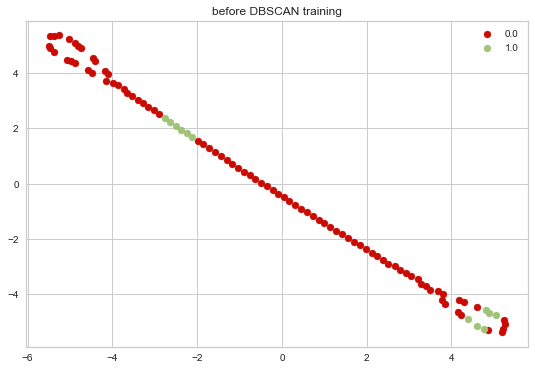

In [13]:
draw_Tsne(X,Y,"before DBSCAN training")

## Mapping the predicted labels from the clusters with the accual labels

In [14]:
def unsupervisedLabelMap(labels, y):
    labelDict = dict()
    for label in unique_labels(labels):
        tmpY = y[labels == label]
        unique, count = np.unique(tmpY, return_counts=True)
        trueLabel = unique[np.argmax(count)]
        labelDict[label] = trueLabel
    return labelDict


def usLabels2sLabels(labels, y):
    sLabels = np.empty(labels.shape, labels.dtype)
    labelDict = unsupervisedLabelMap(labels, y)
    for usl, tl in labelDict.items():
        sLabels[labels == usl] = tl
    return sLabels

## Finding the best hyperparmeters for DBSCAN (eps ,min_samples) that gives the highest accuracy score

[0. 1.]


100%|██████████| 6/6 [00:00<00:00, 35.93it/s]


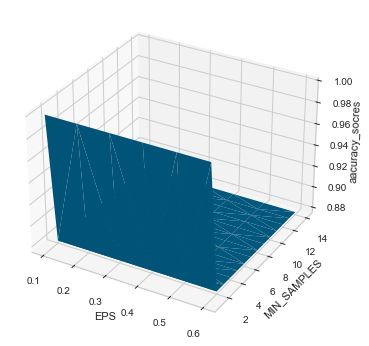

the best n_clustrs = 2 with accuracy_socres = 1.0 and eps = 0.1, min_samples =1


In [15]:
#Using original Training Data
rs = 0
X, y = X, Y
_, dim = X.shape
classes = unique_labels(y)
print(classes)
# DBSCAN_silhouette_socres = []
accuracy_socres = []
epsList, msList, n_clusters = [], [], []
# l = []
y_predected =[]
for eps in tqdm(np.arange(0.1, 0.7, 0.1)):
  for ms in range(1, 15):
    model = DBSCAN(eps=eps, min_samples=ms)
    predClusters = model.fit_predict(X)
    # print(unique_labels(predClusters))
    predY = usLabels2sLabels(predClusters, y)
    accuracy = accuracy_score(y, predY)    
    # score = silhouette_score(X, predClusters, random_state=0)
    # DBSCAN_silhouette_socres.append(score)
    accuracy_socres.append(accuracy)
    # labels = model.labels_
    # l.append(labels)
    y_predected.append(predY)
    epsList.append(eps)
    msList.append(ms)
    n_clusters.append(len(np.unique(predY)))

epsList, msList, n_clusters,accuracy_socres = np.array(epsList), np.array(msList), np.array(n_clusters), np.array(accuracy_socres)

ax = plt.axes(projection='3d')
ax.plot_trisurf(epsList, msList, accuracy_socres)
ax.set_xlabel('EPS')
ax.set_ylabel('MIN_SAMPLES')
ax.set_zlabel('aacuracy_socres')
plt.show()
i = accuracy_socres.argmax()
print(f"the best n_clustrs = {n_clusters[i]} with accuracy_socres = {accuracy_socres[i]} and eps = {epsList[i]}, min_samples ={msList[i]}")


In [21]:
target_names = [f'class {x}' for x in unique_labels(y_predected[i])]
# print(target_names)
print(classification_report(Y, y_predected[i], target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        86
     class 1       1.00      1.00      1.00        12

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



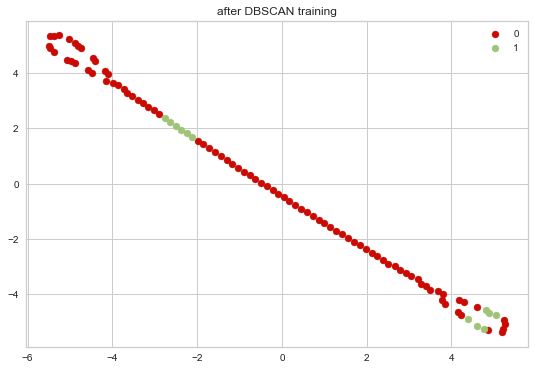

In [16]:
draw_Tsne(X,y_predected[i],"after DBSCAN training")
